# **AstrID:**  *model training*

In [ ]:
# Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.preprocessing import image
from keras.initializers import he_uniform
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.optimizers import Adam
from sklearn.utils import class_weight

# Import other necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import getpass
import pandas as pd
from astropy.io import fits

# Import custom model function
from models.unet import unet_model

# Import custom functions to extract Image arrays and Pixel Mask arrays from our created fits files dataset
from dataGathering import extractImageArray, extractPixelMaskArray, extract_star_catalog
from dataGathering import getStarData, getImagePlot, getPixelMaskPlot
from dataGathering import displayRawImage, displayRawPixelMask, displayImagePlot, displayPixelMaskPlot, displayPixelMaskOverlayPlot
from dataGathering import importDataset

# Import custom functions to preprocess Image and Pixel Mask arrays
from imageProcessing import normalizeImages, stackImages, stackMasks, preprocessImage

# Import custom logging function
from log import write_to_log


2024-11-22 15:28:55.194784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 15:28:57.249132: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-11-22 15:29:03.051870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 15:29:03.331677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 15:29:03.336592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available")
    
    # Clear GPU memory
    K.clear_session()
    tf.config.experimental.reset_memory_stats('GPU:0')

2024-11-22 15:29:03.431952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.


GPU is available


2024-11-22 15:29:03.432432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 15:29:03.432768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 15:29:04.161877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 15:29:04.162280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 15:29:04.162314: I tensorflow/core/co

In [4]:
# Create images and masks arrays lists
images = []
masks = []

# Create df to store the star data inside each fits file
star_data = []

images, masks, star_data = importDataset(dataset_path='data/fits/', dataset_name='data')

data47.fits added to dataset
data8.fits added to dataset
data93.fits added to dataset
data202.fits added to dataset
data79.fits added to dataset
data116.fits added to dataset
data187.fits added to dataset
data100.fits added to dataset
data10.fits added to dataset
data91.fits added to dataset
data34.fits added to dataset
data117.fits added to dataset
data148.fits added to dataset
data107.fits added to dataset
data38.fits added to dataset
data134.fits added to dataset
data238.fits added to dataset
data136.fits added to dataset
data5.fits added to dataset
data189.fits added to dataset
data33.fits added to dataset
data223.fits added to dataset
data162.fits added to dataset
data13.fits added to dataset
data28.fits added to dataset
data208.fits added to dataset
data118.fits added to dataset
data197.fits added to dataset
data143.fits added to dataset
data178.fits added to dataset
data102.fits added to dataset
data200.fits added to dataset
data129.fits added to dataset
data174.fits added to da

# Prepare the data for training

### Convert to 3-Channel Images

The images we have are 512 x 512 pixels, but our model requires them to be in the shape `(512, 512, 3)`, similar to standard RGB images. To achieve this, we stack the single-channel images along the last axis three times, converting them into 3-channel images. This transformation is necessary because the model typically expects 3-channel input images.

For the masks, the model expects them to be in the shape `(512, 512, 1)`. Therefore, we expand the masks along the last axis to add a new dimension, ensuring they have the correct shape.

Additionally, both the images and masks need to be converted to NumPy arrays, as this is the desired format for the training model. Below, we perform these conversions to ensure the data is in the correct format for training.

Notice when displaying the shape of the `train_images` list below we see it is an array of 250 images of the shape mentioned above, giving us a shape `(250, 512, 512, 3)`

In [6]:
stacked_images = stackImages(images)
stacked_masks = stackMasks(masks)

### Normalize the Images

To standardize the pixel values in our images, we need to normalize them to a common range.
We will use min-max normalization to scale the pixel values to a range between 0.0 and 1.0.

In [7]:
# normalized_images = normalizeImages(stacked_images)

###  Prepare the model for training


In [8]:
# Define hyperparameters

learning_rate = 0.0001

hyperparameters = {
    'input_shape': (512, 512, 3),
    'filters': [64, 128, 256, 512, 1024],
    'kernel_size': (3, 3),
    'activation': 'relu',
    # 'activation': 'leaky_relu',
    'padding': 'same',
    'initializer': he_uniform,
    'learning_rate': 0.00001,
    'optimizer': 'Adam(learning_rate=0.0001)',
    'loss': 'binary_crossentropy',
    'weights' : {0 : 1.0, 1 : 5.5},
    'metrics': ['accuracy'],
    'epochs': 1000,
    'batch_size': 4,
    'early_stopping_patience': 10,
    'test_size': 0.2,
    'random_state': 0,
    'seed': 42
}

# Create the optimizer using the stored learning rate
optimizer = Adam(learning_rate=hyperparameters['learning_rate'])

# Create and compile the model using hyperparameters
model = unet_model(
    input_shape=hyperparameters['input_shape'],
    filters=hyperparameters['filters'],
    kernel_size=hyperparameters['kernel_size'],
    activation=hyperparameters['activation'],
    padding=hyperparameters['padding'],
    initializer=hyperparameters['initializer']
)
model.compile(
    optimizer=optimizer,
    loss=hyperparameters['loss'],
    metrics=hyperparameters['metrics']
)

**Split the Dataset for Training and Validation**:

In [9]:
# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(stacked_images, stacked_masks, test_size=hyperparameters['test_size'], random_state=hyperparameters['random_state'])

In [10]:
# Show distribution of training and validation sets
print('Training images: ', train_images.shape)
print('Training masks: ', train_masks.shape)
print('Validation images: ', val_images.shape)
print('Validation masks: ', val_masks.shape)

Training images:  (200, 512, 512, 3)
Training masks:  (200, 512, 512, 1)
Validation images:  (50, 512, 512, 3)
Validation masks:  (50, 512, 512, 1)


# Train the model

In [ ]:
# Implement Early stopping to cut useless epochs
early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric like 'val_accuracy'
    patience=hyperparameters['early_stopping_patience'],         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restores the model to the best state after stopping
)


# Train the model
history = model.fit(
    train_images, train_masks, 
    validation_data=(val_images, val_masks), 
    epochs=hyperparameters['epochs'], 
    batch_size=hyperparameters['batch_size'],
    callbacks=[early_stopping],
    class_weight=hyperparameters['weights']
)

Epoch 1/1000


2024-11-21 21:36:55.807452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-21 21:36:57.904491: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd3b8cf6560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-21 21:36:57.904531: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-11-21 21:36:57.911516: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-21 21:36:58.010409: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-11-21 21:36:59.326842: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The call

50/50 [==============================] - 39s 396ms/step - loss: 66.8868 - accuracy: 0.9691 - val_loss: 13.5812 - val_accuracy: 0.9713
Epoch 2/1000
50/50 [==============================] - 17s 343ms/step - loss: 35.6567 - accuracy: 0.9639 - val_loss: 9.0565 - val_accuracy: 0.9739
Epoch 3/1000
50/50 [==============================] - 17s 340ms/step - loss: 27.9206 - accuracy: 0.9635 - val_loss: 7.5183 - val_accuracy: 0.9726
Epoch 4/1000
50/50 [==============================] - 16s 311ms/step - loss: 24.3083 - accuracy: 0.9644 - val_loss: 8.2421 - val_accuracy: 0.9589
Epoch 5/1000
50/50 [==============================] - 16s 313ms/step - loss: 22.1724 - accuracy: 0.9637 - val_loss: 7.6227 - val_accuracy: 0.9572
Epoch 6/1000
50/50 [==============================] - 16s 315ms/step - loss: 20.1817 - accuracy: 0.9633 - val_loss: 8.2824 - val_accuracy: 0.9430
Epoch 7/1000
50/50 [==============================] - 16s 316ms/step - loss: 19.2576 - accuracy: 0.9658 - val_loss: 7.5773 - val_accurac

In [ ]:
user = getpass.getuser()

# Save the model
saved_models_path = 'models/saved_models/'
training_size = str(len(train_images))
saved_model_name = datetime.datetime.now().strftime("%Y_%m_%d-%H%M_") + training_size + '_unet_model_' + user +  '.keras'
model.save(saved_models_path + saved_model_name)

#log model parameters, time, and user
write_to_log(history, hyperparameters, saved_model_name)

In [13]:
# Show training loss and validation loss
print('Training loss: ', history.history['loss'][-1])
print('Validation loss: ', history.history['val_loss'][-1])

# Show training accuracy and validation accuracy
print('Training accuracy: ', history.history['accuracy'][-1])
print('Validation accuracy: ', history.history['val_accuracy'][-1])

Training loss:  4.691247463226318
Validation loss:  1.769013524055481
Training accuracy:  0.9644006490707397
Validation accuracy:  0.9658341407775879


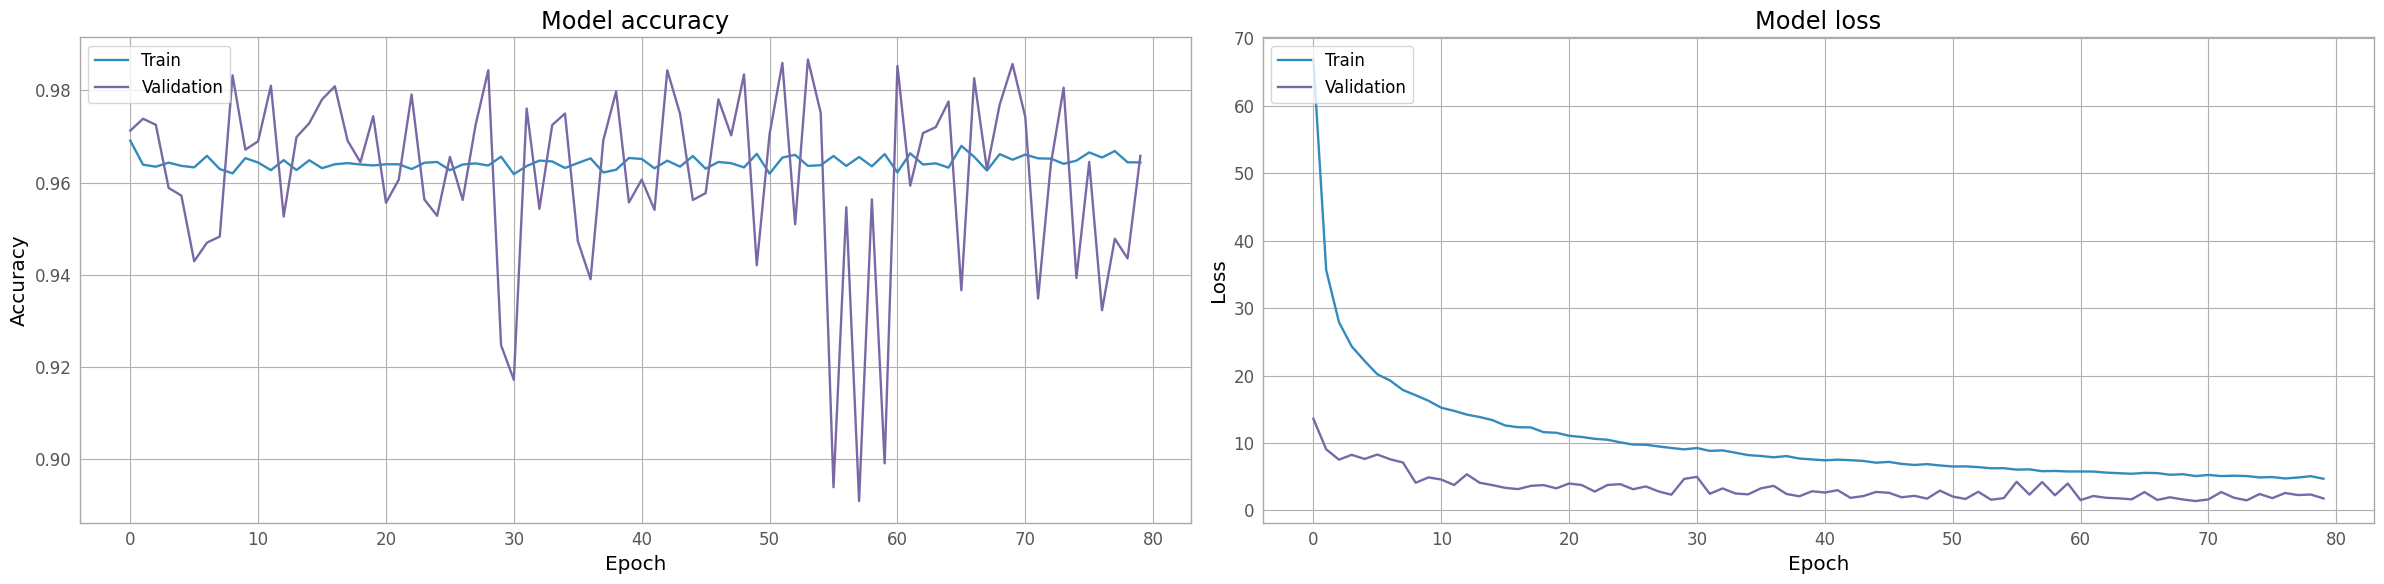

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('results/figures/' + saved_model_name.removesuffix('_unet_model_' + user +  '.keras') + '_training_validation.png')
plt.show()

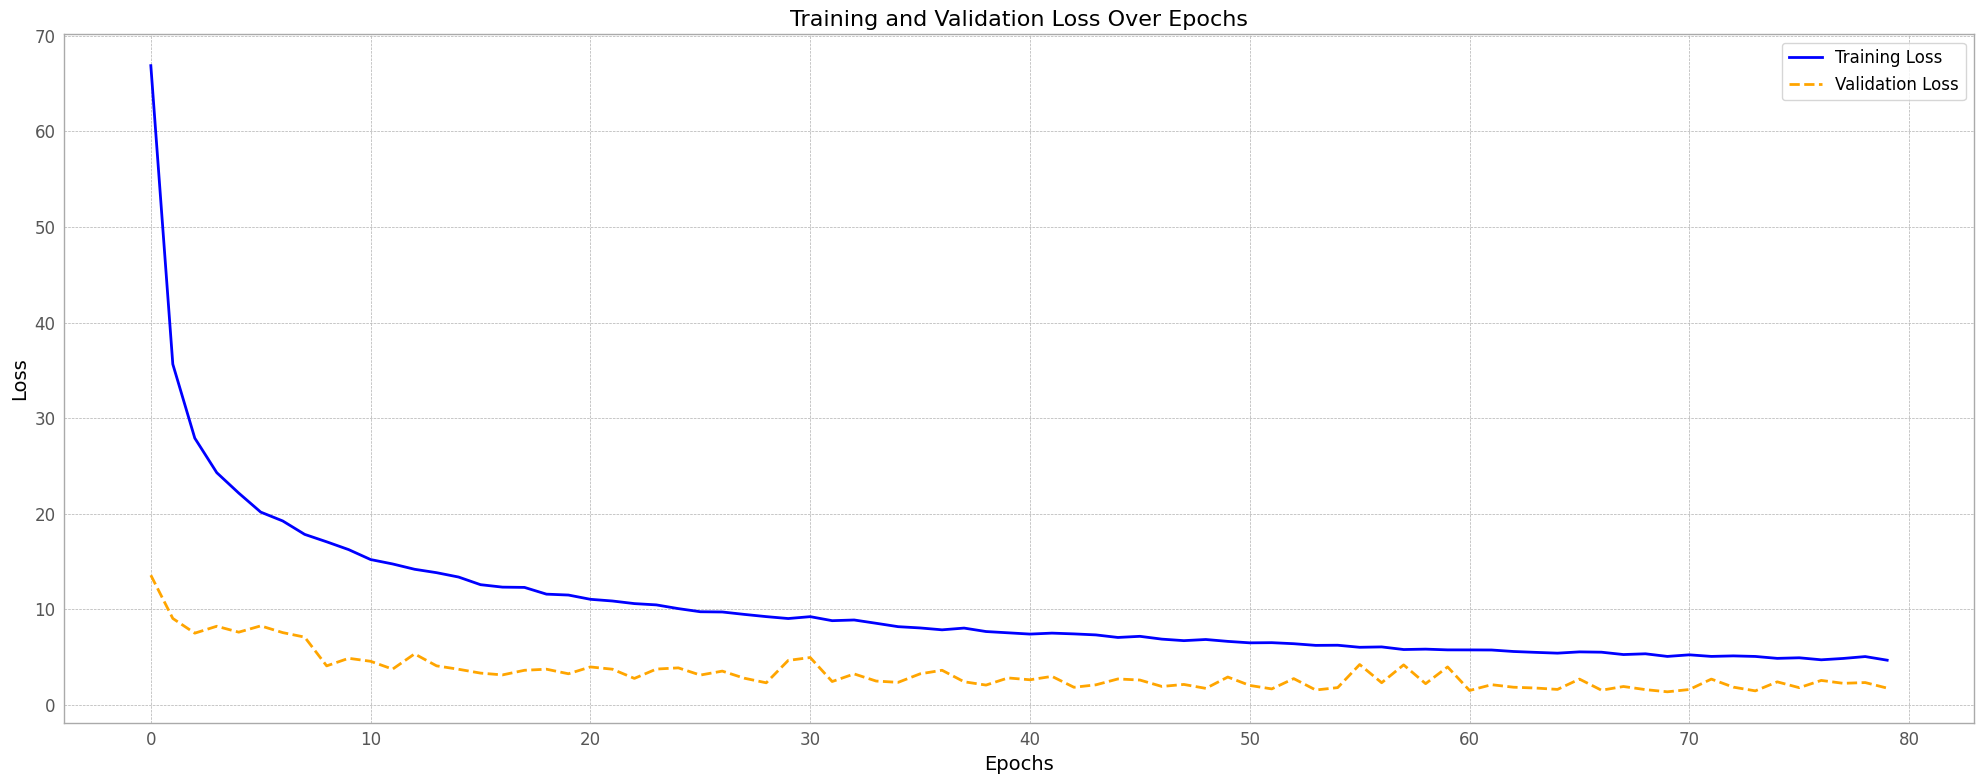

In [15]:
# Set a larger figure size
plt.figure(figsize=(20, 8))

# Plot the training and validation loss
plt.plot(history.history['loss'], color='blue', linestyle='-', linewidth=2, label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', linestyle='--', linewidth=2, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend to differentiate between training and validation loss
plt.legend(loc='best', fontsize=12)

# Show the plot
plt.tight_layout()
plt.savefig('results/figures/' + saved_model_name.removesuffix('_unet_model_' + user +  '.keras') + '_training_validation_loss.png')
plt.show()
